### Part 1 Rule 184

Rule 184 is a one-dimensional binary cellular automaton rule.  It could be used in traffic flow simulation:  

\begin{equation}\label{184}
n_i(t+1)=n_{i-1}[1-n_i(t)]+n_i(t)n_{i+1},
\end{equation}

where $n_i(t)$ is the state of the cell $i$.  $n_i(t)=1$ means it is occupied and $n_i(t)=0$ means it is empty.  Cell $i-1$ is the previous cell and cell $i+1$ is the target cell.  From the equation, one knows vehicles move forward if there is open space in front of them, and otherwise they stop.

### Part 2 The network

In this project, we apply the idea of Rule 184 to a single intersection with different control types.  Different control types set different rules of changing states of the cells at the intersection.

### Part 3 The code

First, we will define directions in the system.
Here, 0 is North, and add the number by 1 will change the direction clockwise and vise versa. This makes it easy to operate the turning movement by simple calculatation and taking the reminder of 4.

A python dictonary is used here to record possible directions of a given road block. If going to this direction on the road block is possible, the dictonary will return the change in coordinate in respect of y and x. Otherwise it will return a None object. 


In [1]:
# direction of road block
'''
Direction 0: North 1: East  2: South 3: West 
'''
N = {0: [-1, 0], 1: None, 2: None, 3: None}
W = {0: None, 1: None, 2: None, 3: [0, -1]}
S = {0: None, 1: None, 2: [1, 0], 3: None}
E = {0: None, 1: [0, 1], 2: None, 3: None}

NW = {0: [-1, 0], 1: None, 2: None, 3: [0, -1]}
SW = {0: None, 1: None, 2: [1, 0], 3: [0, -1]}
SE = {0: None, 1: [0, 1], 2: [1, 0], 3: None}
NE = {0: [-1, 0], 1: [0, 1], 2: None, 3: None}

X = 'X'

Second, we can define the car obejct. 
We need the following 3 arguments to define a car:

(i) `comm`: command of the driver. This indecates where the driver wants to go. It is repersented by a string. 'L', 'R', and 'D' repersent Left, Right and Direct respectively. 

(ii) `delay`: the driver will to turn to desired direction at a delayed time. This is used for multi-intersection simulation. If this number is 1, the driver will skip the first chance to turn, and continue to the next chance to turn. 

(iii) `direction`：the original direction of the car.

Also, we will need one flag to mark whether the car is being moved or not in this turn of each update.

In [2]:
class car(object):
	def __init__(self, comm, delay, direction):
		self.direction = direction
		if comm == 'L':
			self.comm = (direction - 1) % 4
		if comm == 'R':
			self.comm = (direction + 1) % 4
		elif comm == 'D':
			self.comm = direction
		self.delay = delay
		self.moved = False


Thirdly, we will have to define the road block object. This is the basic compoment of map. 

They is only one required proporty of the road: direction. This is the road block direction as dictionary that we defined before. 

Road blocks can have different functionallities. 

(1) If a road block is a respawn point, this road block will automatically regenerate new cars. Here we need:

`spawnint`- respawn interval as a intger

`spawndir`- respawn direction as a integer. (0: North 1: East  2: South 3: West)

The generated vehicle has pre-set a left and right-turn rate of 0.1, and go-stright rate of 0.8.

(2) If a road block is a traffic light, it will stop the vehicle at red. The traffic light requires three argument: 
(i) `trafficlight`- green light duration, as a integer 
(ii) `trafficlight_stop`- red light duration, as a integer
(iii) `trafficlightinit`- the initial state of light, as a boolean


Also, we need some basic operation of the road block. 
`put_car(car)` takes a car object, and place it on the road.
`pop_car()` remove the current car, and return the car object.
those functions are used to update the state.



In [3]:
class road(object):
	def __init__(self, dir, spawnint=None, spawndir=None, spawndelay=0, trafficlight=None, trafficlight_stop=0, trafficlightinit = True):
		self.car = None
		self.dir = dir

		self.spawn = spawnint
		if spawnint != None:
			self.spawncounter = spawndelay
			self.Lrate = 0.1
			self.Rrate = 0.1
			self.Drate = 0.8
			self.spawndir = spawndir

		self.trafficlight = trafficlight


		if trafficlight:
			self.trafficlight_stat = trafficlightinit
			self.trafficlight_go_period = trafficlight
			self.trafficlight_stop_period = trafficlight_stop
			self.trafficlight_counter = trafficlight

	def add_car(self, car):
		self.car = car

	def pop_car(self):
		out = self.car
		self.car = None
		return out

	def __str__(self):
		if self.car == None:
			return 'N'
		else:
			return str(self.car.comm)

Lastly, it is the main map object. To create a map object, you will need a 2D array. Each element in the array could be a road block object (with des function), or a string 'X' to repersent there is no road in this block. 

Here's some defination of functions in map object:

`put_car(coordy, coordx, carcomm, cardelay, cardir)`: manually put a car with given perpority (carcomm, cardelay, cardir) at given place(coordy, coordx)

`update()`: update the state of the map.

`construct_ref()`: construct a reference matrix of the road condition. This is used to in the update() function to avoid double-count.

`update_and_plot(n_iter`): using matplotlib to plot and live update the situation of the map for given interations (n_iter). 

Also, call python `print()` function on map object will return current state of map, repersented as a string. Here is a example:


```
	X	X	X	2	N	X	X	X
	X	X	N	3	N	X	X	X
	X	X	N	N	N	N	N	X
	N	3	N	3	N	3	3	3
	0	0	1	N	0	N	N	N
	X	N	N	N	N	N	X	X
	X	X	X	N	0	N	X	X
	X	X	X	2	0	X	X	X
```

Where:

`X`: no road 

`N`: empty road 

`0`,`1`,`2`,`3`: car on road. the number repersent the desired travel direction of car




In [4]:
class map(object):
	def __init__(self, input_arr):
		self.cellmap = input_arr
		self.max_y = len(input_arr)
		self.max_x = len(input_arr[0])
		self.systime = 0
		self.spawncount = 0
		self.exitcount = 0

	def put_car(self, coordy, coordx, carcomm, cardelay, cardir):
		self.cellmap[coordy][coordx].add_car(car(carcomm, cardelay, cardir))

	def update(self):
		self.systime += 1
		ref_cellmap = self.construct_ref()
		# set all cars unmoved.
		for y in range(self.max_y):
			for x in range(self.max_x):
				cell = self.cellmap[y][x]
				if cell != X:  # is a road
					if cell.car:  # has a car
						cell.car.moved = False

		for y in range(self.max_y):
			for x in range(self.max_x):
				cell = self.cellmap[y][x]
				if cell != X:  # is a road
					if cell.car:  # has a car, hasn't moved
						if cell.car.moved:
							continue
						cell.car.moved = True
						if cell.dir[cell.car.comm] == None:  # can not execute turn
							ny = y + cell.dir[cell.car.direction][0]
							nx = x + cell.dir[cell.car.direction][1]
						else:
							ny = y + cell.dir[cell.car.comm][0]
							nx = x + cell.dir[cell.car.comm][1]
						if nx < 0 or nx > self.max_x - 1 or ny < 0 or ny > self.max_y - 1:
							# go out of map
							cell.pop_car()
							self.exitcount += 1
						else:
							next_cell = self.cellmap[ny][nx]
							ref_next_cell = ref_cellmap[ny][nx]

							if ref_next_cell == 0:
								if cell.trafficlight:
									if cell.trafficlight_stat == True:
										move_car = cell.pop_car()
										next_cell.add_car(move_car)
								else:
									move_car = cell.pop_car()
									next_cell.add_car(move_car)

					if cell.spawn != None:  # is a spawn point
						if cell.spawncounter != 0:  # not yet the time
							cell.spawncounter -= 1
						else:  # it's the time
							refmap_spawn = self.construct_ref()
							if refmap_spawn[y][x] == 0:
								cell.spawncounter = cell.spawn
								spawncomm = np.random.choice(['L', 'R', 'D'], 1, p=[cell.Lrate, cell.Rrate, cell.Drate])
								self.put_car(y, x, spawncomm, 0, cell.spawndir)
								self.spawncount += 1

					if cell.trafficlight:
						#change state:
						if cell.trafficlight_counter != 0:
							cell.trafficlight_counter -= 1
						else:
							if cell.trafficlight_stat == True:
								cell.trafficlight_stat = False
								cell.trafficlight_counter = cell.trafficlight_stop_period
							else:
								cell.trafficlight_stat = True
								cell.trafficlight_counter = cell.trafficlight_go_period





	def construct_ref(self):
		ref_cellmap = []
		for item in self.cellmap:
			ref_cellmap.append(item.copy())
		for y in range(self.max_y):
			for x in range(self.max_x):
				cell = self.cellmap[y][x]
				if cell != X:  # is a road
					if cell.car == None:
						ref_cellmap[y][x] = 0
					else:
						ref_cellmap[y][x] = 1
		return ref_cellmap

	def update_and_plot(self, n_iter):

		# plt.ion()
		plt.ion()
		for _ in range(n_iter):
			self.update()
			plot_cellmap = np.zeros((self.max_y, self.max_x))
			for y in range(self.max_y):
				for x in range(self.max_x):
					cell = self.cellmap[y][x]
					if cell != X:  # is a road
						if cell.car:  # has a car
							plot_cellmap[y, x] = 2
						else:
							plot_cellmap[y, x] = 1

			plt.title('Iter :{}'.format(self.systime))
			plt.imshow(plot_cellmap)
			plt.pause(0.2)
		plt.ioff()

	def plot(self):
		plot_cellmap = np.zeros((self.max_y, self.max_x))
		for y in range(self.max_y):
			for x in range(self.max_x):
				cell = self.cellmap[y][x]
				if cell != X:  # is a road
					if cell.car:  # has a car
						plot_cellmap[y, x] = 2
					else:
						plot_cellmap[y, x] = 1
		plt.imshow(plot_cellmap)
		plt.show()

### Part 4 1-D Simulation

Before we implement the model on the 2-D road, let us show how the Rule 184 works on a one lane road.  Here is a one-lane eastbound road, which consists of 8 blocks.  Cars enter the road from west (block 0).  

If at time $t$, there is a car on block $i$, i.e. $n_i(t)=1$, then the block $i$ is shown in yellow. 

If at time $t$, there is no car on block $i$, i.e. $n_i(t)=0$, then the block $i$ is shown in purple. 

In the example below, we show how the system evolves from $t=0$ to $t=7$ base on rule 184.

time 0


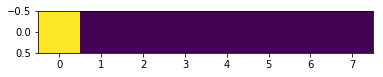

time 1


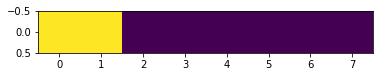

time 2


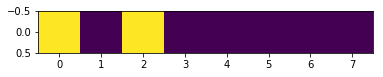

time 3


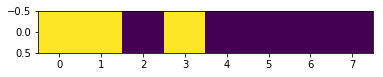

time 4


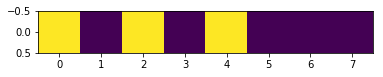

time 5


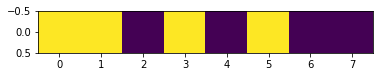

time 6


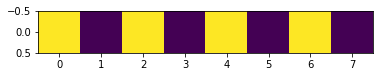

time 7


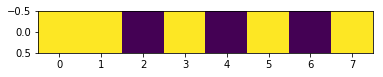

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# define road input here
input_map = [
    [road(E, 0, 1), road(E), road(E), road(E), road(E), road(E), road(E), road(E)]
]

game = map(input_map)
for x in range(8):
    game.update()
    print ("time",x)
    game.plot()

### Part 5 Traffic simulation at an intersection

To simulate traffic at an intersection.  We simply need to change the input map in the code.  Now we have an intersection with four approaches.  Vehicles have a 80% probability to go straight at the intersection, 10% to turn left and 10% to turn right. 


### Case 1: No control

We run the simulation with different vehicle spawn rate (traffic flow entry rate).

#### Visulization

#### Low spawn rate

time 0


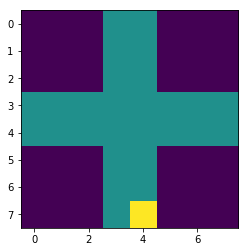

time 1


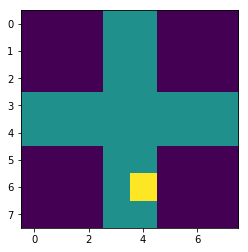

time 2


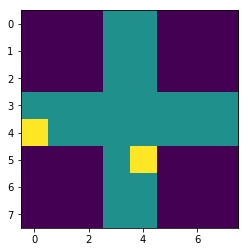

time 3


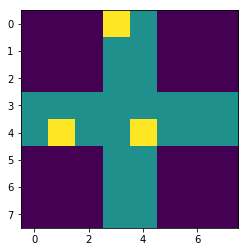

time 4


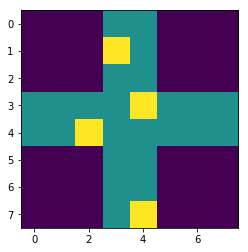

time 5


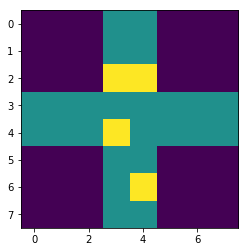

time 6


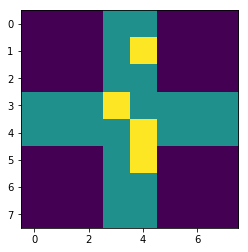

time 7


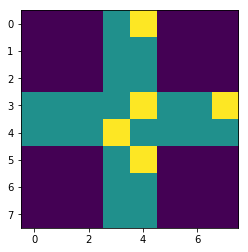

time 8


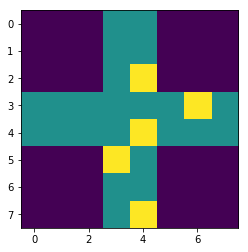

time 9


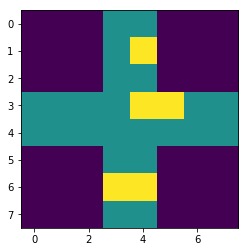

In [7]:
input_map = [[X, X, X, road(S, 10, 2, spawndelay = 3), road(N), X, X, X],
				 [X, X, X, road(S), road(N), X, X, X],
				 [X, X, X, road(S), road(N), X, X, X],
				 [road(W), road(W), road(W), road(SW), road(NW), road(W), road(W), road(W, 10, 3, spawndelay = 7)],
				 [road(E, 10, 1, spawndelay = 2), road(E), road(E), road(SE), road(NE), road(E), road(E), road(E)],
				 [X, X, X, road(S), road(N), X, X, X],
				 [X, X, X, road(S), road(N), X, X, X],
				 [X, X, X, road(S), road(N, 3, 0), X, X, X]
				 ]

game = map(input_map)

for x in range(10):
    game.update()
    print ("time",x)
    game.plot()

#### Median spawn rate

time 0


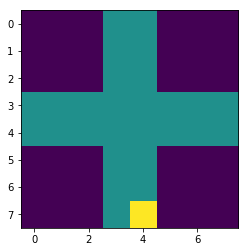

time 1


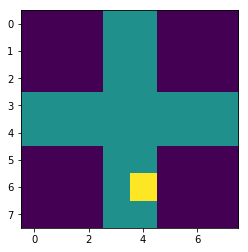

time 2


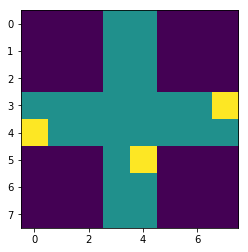

time 3


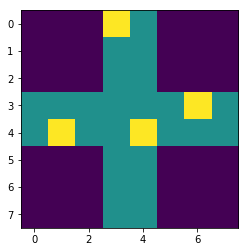

time 4


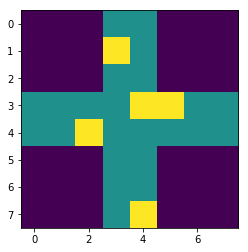

time 5


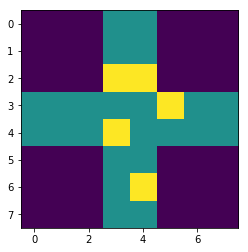

time 6


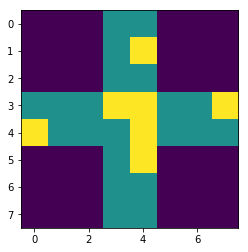

time 7


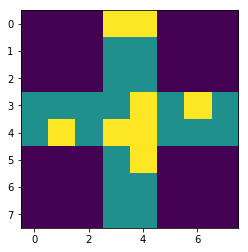

time 8


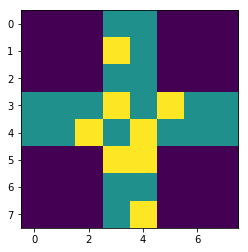

time 9


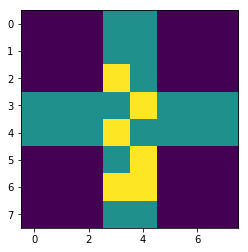

In [8]:
input_map = [[X, X, X, road(S, 3, 2, spawndelay = 3), road(N), X, X, X],
				 [X, X, X, road(S), road(N), X, X, X],
				 [X, X, X, road(S), road(N), X, X, X],
				 [road(W), road(W), road(W), road(SW), road(NW), road(W), road(W), road(W, 3, 3, spawndelay = 2)],
				 [road(E, 3, 1, spawndelay = 2), road(E), road(E), road(SE), road(NE), road(E), road(E), road(E)],
				 [X, X, X, road(S), road(N), X, X, X],
				 [X, X, X, road(S), road(N), X, X, X],
				 [X, X, X, road(S), road(N, 3, 0), X, X, X]
				 ]

game = map(input_map)

for x in range(10):
    game.update()
    print ("time",x)
    game.plot()

#### High spawn rate

time 0


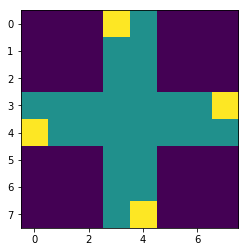

time 1


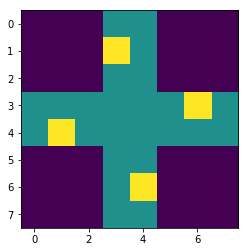

time 2


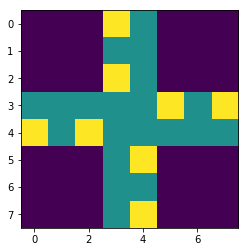

time 3


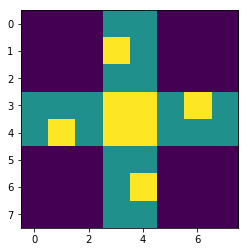

time 4


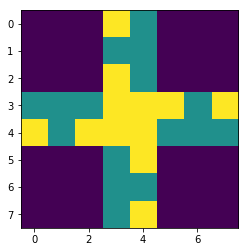

time 5


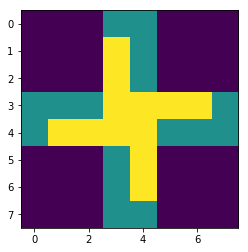

time 6


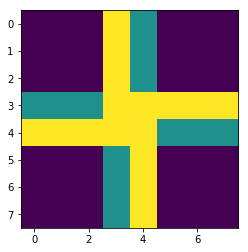

time 7


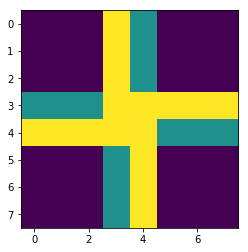

time 8


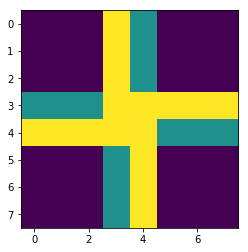

time 9


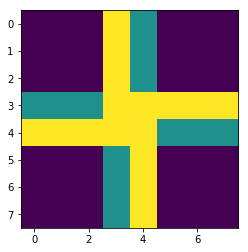

In [9]:
input_map = [[X, X, X, road(S, 1, 2, spawndelay = 0), road(N), X, X, X],
				 [X, X, X, road(S), road(N), X, X, X],
				 [X, X, X, road(S), road(N), X, X, X],
				 [road(W), road(W), road(W), road(SW), road(NW), road(W), road(W), road(W, 1, 3, spawndelay = 0)],
				 [road(E, 1, 1, spawndelay = 0), road(E), road(E), road(SE), road(NE), road(E), road(E), road(E)],
				 [X, X, X, road(S), road(N), X, X, X],
				 [X, X, X, road(S), road(N), X, X, X],
				 [X, X, X, road(S), road(N, 1, 0), X, X, X]
				 ]

game = map(input_map)

for x in range(10):
    game.update()
    print ("time",x)
    game.plot()

As we can see from the output, for an intersection with low traffic flow rate, we do not need to use traffic control.  However, when the traffic flow rate increases, significant delay can be noticed at the intersection.  When the traffic flow rate is high enough, the vehicles stuck at the intersection.  The results show that traffic control at intersection is needed.

#### Quantify the outflow

The variable exitcount record the number of vehicles that exits the system.  We here define the function "exitno", such that given the spawn inteval and total simulation time, we can get the outflow of the system.

In [10]:
# calculate outflow for the no-control case for one time
import random
def exitno(n,time):
    input_map = [[X, X, X, road(S, n, 2, spawndelay = random.randint(1,n)), road(N), X, X, X],
				 [X, X, X, road(S), road(N), X, X, X],
				 [X, X, X, road(S), road(N), X, X, X],
				 [road(W), road(W), road(W), road(SW), road(NW), road(W), road(W), road(W, n, 3, spawndelay = random.randint(1,n))],
				 [road(E, n, 1, spawndelay = random.randint(1,n)), road(E), road(E), road(SE), road(NE), road(E), road(E), road(E)],
				 [X, X, X, road(S), road(N), X, X, X],
				 [X, X, X, road(S), road(N), X, X, X],
				 [X, X, X, road(S), road(N, n, 0, spawndelay = random.randint(1,n)), X, X, X]
				 ]
    game = map(input_map)
    
    for x in range(time):
        game.update()
    return game.exitcount   

An example is given for how to calculate the outflow rate of the intersection in vehicle/hr.  For a 4-second spawn interval (spawn interval is 3 in the code), the flow rate of the intersection is estimated as 2337 vehicle/hr, using 20 repeated simulation runs.  The efficiency of the intersection can be calculated as outflow divided by inflow.  

The inflow is $\frac{3600 \times 4}{spawn\ interval}$ vehicles/hr

(note: there are four entries)

We get that the efficiency of the intersection for a 4-second vehicle spawn interval is around 65%.

In [13]:
# example for a 4-second vehicle spawn interval.  Taking the average of 20 runs
import random
sum = 0
sims = 20 # number of repeat simulations
time = 500 # simulation duration
for x in range(sims):
    exit = exitno(3,time)
    sum += exit
avg = sum/(sims*time)
flow = round(avg * 3600) #change to vehicle/hr
eff = flow / (14400 / (3+1))
print(flow)
print(eff)

2337
0.6491666666666667


#### Draw flow-density curve

In the curve, we can use vehicle density as our X variable.  To get the input vehicle denstity, $k=\frac{q_{in}}{u}$.  

In our case, $q_{in}=\frac{14400}{spawn\ interval}$.  

A typical value of the free-flow speed $u$ is $60$ km/h. 

In [14]:
# calculate density
def den(n):
    return (14400/(60*(n+1)))

The method to calculate outflow and effiency is taught in the last section.

In [15]:
# OUTFLOW (avg of 20 runs)
def outflow(n):
    sum = 0
    sims = 20 # number of repeat simulations
    time = 500 # simulation duration
    for x in range(sims):
        exit = exitno(n,time)
        sum += exit
    avg = sum/(sims*time)
    flow = round(avg * 3600)
    return flow

# EFFICIENCY (avg of 20 runs)
def eff(n):
    sum = 0
    sims = 20 # number of repeat simulations
    time = 500 # simulation duration
    for x in range(sims):
        exit = exitno(n,time)
        sum += exit
    avg = sum/(sims*time)
    flow = round(avg * 3600)
    eff = flow / (14400 / (n+1))
    return eff

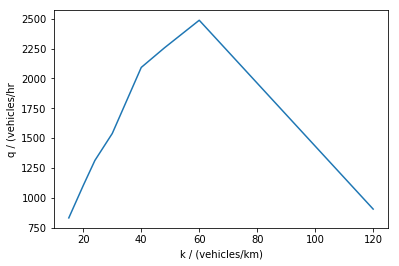

In [16]:
plt.plot([den(1),den(3),den(4),den(5),den(7),den(9),den(11),den(15)],
         [outflow(1),outflow(3),outflow(4),outflow(5),outflow(7),outflow(9),outflow(11),outflow(15)])
plt.xlabel('k / (vehicles/km)')
plt.ylabel('q / (vehicles/hr')
plt.show()

As we can see, the outflow increases with density and then decreases.  This result is consistent with the traigular fundamental diagram in traffic flow theory.

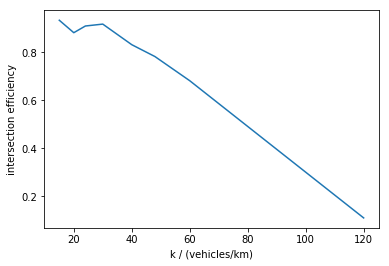

In [17]:
plt.plot([den(1),den(3),den(4),den(5),den(7),den(9),den(11),den(15)],
         [eff(1),eff(3),eff(4),eff(5),eff(7),eff(9),eff(11),eff(15)])

plt.xlabel('k / (vehicles/km)')
plt.ylabel('intersection efficiency')
plt.show()

The efficiency of the intersection decreases with vehicle density.  When the vehicle density is 80 vehicle/km, the efficiency of the intersection is only 0.5.  So if an intersection has a high traffic flow rate, traffic control is needed for this intersection.

### Case 2: Signal control

By changing the input_map variable, we can add signal control to the intersecion.  Here we present an example with a spawn interval of 2 seconds and traffic light signal of 4 seconds.  At the beginning, the northbound/southbound direction is assigned a green signal and the other direction is assigned a red signal.  From the simulation results, we can see that even when the traffic inflow rate is so high, the intersection can function well.

#### Visulization

time 0


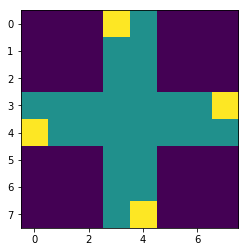

time 1


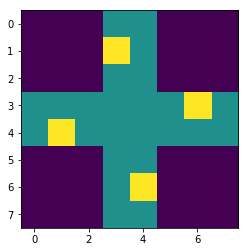

time 2


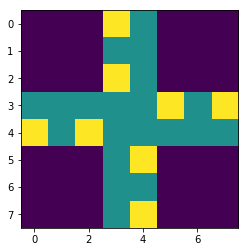

time 3


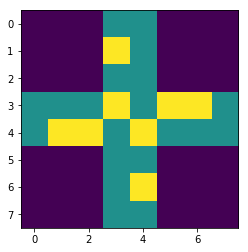

time 4


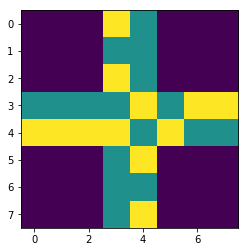

time 5


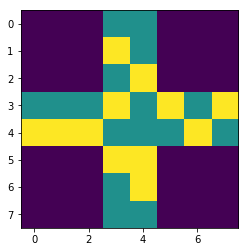

time 6


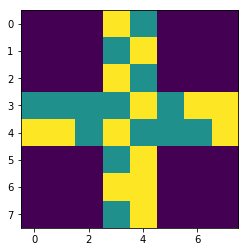

time 7


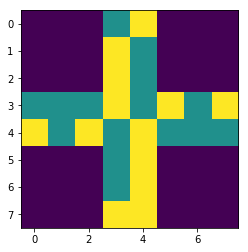

time 8


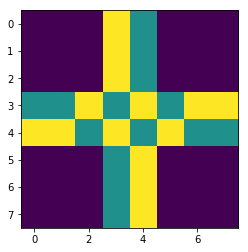

time 9


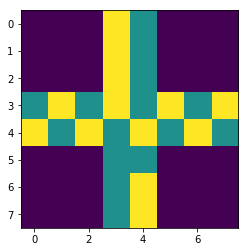

In [18]:
import numpy as np
import matplotlib.pyplot as plt
n = 1 # spawn interval - 1
TL = 4 # half cycle of traffic signal
input_map = [[X, X, X, road(S, n, 2, spawndelay = random.randint(1,n)), road(N), X, X, X],
				 [X, X, X, road(S), road(N), X, X, X],
				 [X, X, X, road(S,trafficlight=TL,trafficlight_stop=TL,trafficlightinit=True), road(N), X, X, X],
				 [road(W), road(W), road(W), road(SW), road(NW), road(W,trafficlight=TL,trafficlight_stop=TL,trafficlightinit=False), road(W), road(W, n, 3, spawndelay = random.randint(1,n))],
				 [road(E, n, 1, spawndelay = random.randint(1,n)), road(E), road(E,trafficlight=TL,trafficlight_stop=TL,trafficlightinit=False), road(SE), road(NE), road(E), road(E), road(E)],
				 [X, X, X, road(S), road(N,trafficlight=TL,trafficlight_stop=TL,trafficlightinit=True), X, X, X],
				 [X, X, X, road(S), road(N), X, X, X],
				 [X, X, X, road(S), road(N, n, 0, spawndelay = random.randint(1,n)), X, X, X]
				 ]

game = map(input_map)
game.update()
for x in range(10):
        game.update()
        print ("time",x)
        game.plot()


#### Quantify the outflow

In [19]:
### calculate out flow for the traffic signal case for one time
import random
def exitnoTL(n, time, TL):
    input_map = [[X, X, X, road(S, n, 2, spawndelay = random.randint(1,n)), road(N), X, X, X],
				 [X, X, X, road(S), road(N), X, X, X],
				 [X, X, X, road(S,trafficlight=TL,trafficlight_stop=TL,trafficlightinit=True), road(N), X, X, X],
				 [road(W), road(W), road(W), road(SW), road(NW), road(W,trafficlight=TL,trafficlight_stop=TL,trafficlightinit=False), road(W), road(W, n, 3, spawndelay = random.randint(1,n))],
				 [road(E, n, 1, spawndelay = random.randint(1,n)), road(E), road(E,trafficlight=TL,trafficlight_stop=TL,trafficlightinit=False), road(SE), road(NE), road(E), road(E), road(E)],
				 [X, X, X, road(S), road(N,trafficlight=TL,trafficlight_stop=TL,trafficlightinit=True), X, X, X],
				 [X, X, X, road(S), road(N), X, X, X],
				 [X, X, X, road(S), road(N, n, 0, spawndelay = random.randint(1,n)), X, X, X]
				 ]
    game = map(input_map)    
    
    for x in range(time):
        game.update()
    return game.exitcount     

In [20]:
# AVG OUTFLOW of 20 runs for the traffic signal case
def outflowTL(n, TL):
    sum = 0
    sims = 20 # number of repeat simulations
    time = 500 # simulation duration
    for x in range(sims):
        exit = exitnoTL(n,time,TL)
        sum += exit
    avg = sum/(sims*time)
    flow = round(avg * 3600)
    return flow

# AVG EFFICIENCY of 20 runs for the traffic signal case
def effTL(n, TL):
    sum = 0
    sims = 20 # number of repeat simulations
    time = 500 # simulation duration
    for x in range(sims):
        exit = exitnoTL(n,time,TL)
        sum += exit
    avg = sum/(sims*time)
    flow = round(avg * 3600)
    eff = flow / (14400 / (n+1))
    return eff

#### Draw flow-density curve for the traffic signal case

Flow-density function plot at an intersection with traffic signal control

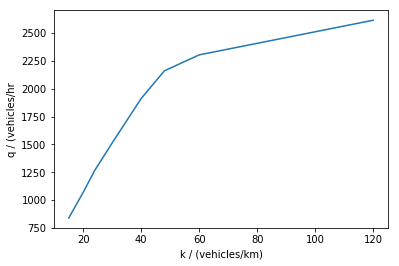

In [21]:
TL = 10
plt.plot([den(1),den(3),den(4),den(5),den(7),den(9),den(11),den(15)],
         [outflowTL(1,TL),outflowTL(3,TL),outflowTL(4,TL),outflowTL(5,TL),outflowTL(7,TL),
          outflowTL(9,TL),outflowTL(11,TL),outflowTL(15,TL)])
plt.xlabel('k / (vehicles/km)')
plt.ylabel('q / (vehicles/hr')
plt.show()

Efficiency-density function plot at an intersection with traffic signal control

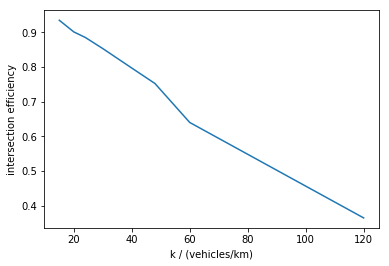

In [22]:
TL = 10
plt.plot([den(1),den(3),den(4),den(5),den(7),den(9),den(11),den(15)],
         [effTL(1,TL),effTL(3,TL),effTL(4,TL),effTL(5,TL),effTL(7,TL),
          effTL(9,TL),effTL(11,TL),effTL(15,TL)])
plt.xlabel('k / (vehicles/km)')
plt.ylabel('intersection efficiency')
plt.show()

Notice that compared to the no-control case, the efficiency of the intersection has been improved from 0.1 to 0.4 given a 120 vehicle/km density.

#### How to optimize the intersection efficiency by adjusting the signal cycle lengh?

In this plot, we show how the cycle length effects the efficiency of the intersection at an density of 80 vehicle/km (spawn interval in the code should be set to 4)

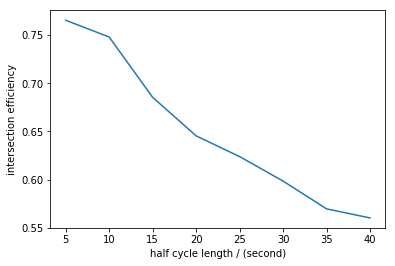

In [24]:
sp = 4
plt.plot([5,10,15,20,25,30,35,40],
         [effTL(sp,5),effTL(sp,10),effTL(sp,15),effTL(sp,20),effTL(sp,25),
          effTL(sp,30),effTL(sp,35),effTL(sp,40)])
plt.xlabel('half cycle length / (second)')
plt.ylabel('intersection efficiency')
plt.show()

The plot shows us that in order to maximize the efficiency of the intersection, the signal cycle length should be set as small as possible.  

However, this is not usually the case in the industry, due to the start-up lost time.  Because when vehicle accelerate at the intersection from a complete stop, there is much time lost such that we do not want to change cycles so frequently.  If we would like to get more accurate results, we can code the start-up lost time into the program.  

### Case 3: Signal control and designated right-turn lanes

Another intersection control method is to add designated right turn lanes to the intersection, such that vehicles turning right do not need to conflict with other vehicles.  Such that right turn vehicles can go at the red light.  In the code, we can implement the right turn lanes by changing the input_map variable. 

#### Visulization

time 0


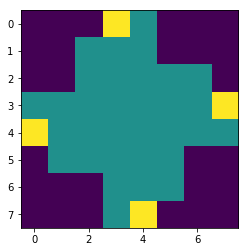

time 1


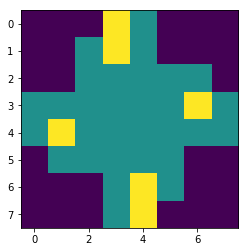

time 2


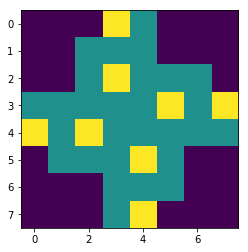

time 3


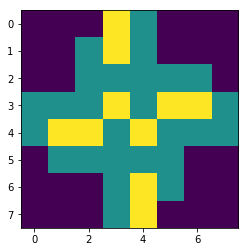

time 4


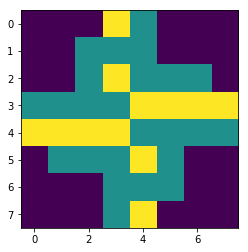

time 5


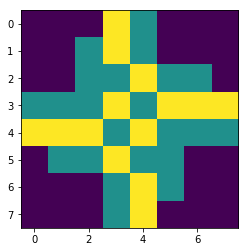

time 6


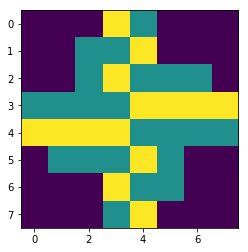

time 7


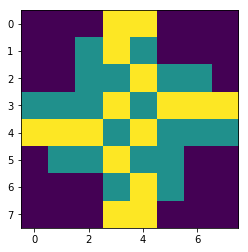

time 8


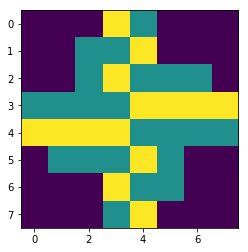

time 9


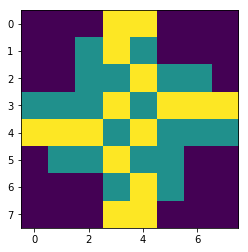

In [25]:
import numpy as np
import matplotlib.pyplot as plt

input_map = [[X, X, X, road(S,0,2), road(N), X, X, X],
				 [X, X, road(S), road(SW), road(N), X, X, X],
				 [X, X, road(S), road(S, trafficlight=10, trafficlight_stop=10, trafficlightinit=True), road(N), road(W), road(W), X],
				 [road(W), road(W), road(W), road(SW), road(NW),road(W, trafficlight=10, trafficlight_stop=10, trafficlightinit=False), road(NW), road(W,1,3)],
				 [road(E,1,1), road(SE), road(E, trafficlight=10, trafficlight_stop=10, trafficlightinit=False),road(SE), road(NE), road(E), road(E), road(E)],
				 [X, road(E), road(E), road(S), road(N, trafficlight=10, trafficlight_stop=10, trafficlightinit=True), road(N), X, X],
				 [X, X, X, road(S), road(NE), road(N), X, X],
				 [X, X, X, road(S), road(N, 0, 0), X, X, X]
				 ]
game = map(input_map)
for x in range(10):
        game.update()
        print ("time",x)
        game.plot()

#### Quantify the outflow

Here we write functions to calculate the efficiency of the intersection with designated right turn lanes:

In [26]:
## calculate outflow for designated right turn lanes case for one time
import random
def exitnoRT(n, time, TL):
    input_map = [[X, X, X, road(S, n, 2, spawndelay = random.randint(1,n)), road(N), X, X, X],
				 [X, X, road(S), road(SW), road(N), X, X, X],
				 [X, X, road(S), road(S,trafficlight=TL,trafficlight_stop=TL,trafficlightinit=True), road(N), road(W), road(W), X],
				 [road(W), road(W), road(W), road(SW), road(NW),road(W,trafficlight=TL,trafficlight_stop=TL,trafficlightinit=False), road(NW), road(W, n, 3, spawndelay = random.randint(1,n))],
				 [road(E, n, 1, spawndelay = random.randint(1,n)), road(SE),road(E,trafficlight=TL,trafficlight_stop=TL,trafficlightinit=False),road(SE), road(NE), road(E), road(E), road(E)],
				 [X, road(E), road(E), road(S), road(N,trafficlight=TL,trafficlight_stop=TL,trafficlightinit=True), road(N), X, X],
				 [X, X, X, road(S), road(NE), road(N), X, X],
				 [X, X, X, road(S), road(N, n, 0, spawndelay = random.randint(1,n)), X, X, X]
				 ]  
    game = map(input_map)    
    
    for x in range(time):
        game.update()
    return game.exitcount   

In [28]:
# AVG OUTFLOW FOR RT case in 20 runs 
def outflowRT(n, TL):
    sum = 0
    sims = 20 # number of repeat simulations
    time = 500 # simulation duration
    for x in range(sims):
        exit = exitnoRT(n,time,TL)
        sum += exit
    avg = sum/(sims*time)
    flow = round(avg * 3600)
    return flow

# AVG EFFICIENCY FOR RT case in 20 runs
def effRT(n, TL):
    sum = 0
    sims = 20 # number of repeat simulations
    time = 500 # simulation duration
    for x in range(sims):
        exit = exitnoRT(n,time,TL)
        sum += exit
    avg = sum/(sims*time)
    flow = round(avg * 3600)
    eff = flow / (14400 / (n+1))
    return eff

Flow-density curve for the designated right-turn lane case

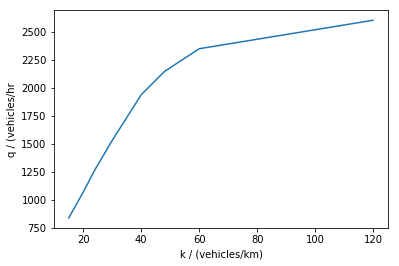

In [29]:
TL = 10
plt.plot([den(1),den(3),den(4),den(5),den(7),den(9),den(11),den(15)],
         [outflowRT(1,TL),outflowRT(3,TL),outflowRT(4,TL),outflowRT(5,TL),outflowRT(7,TL),
          outflowRT(9,TL),outflowRT(11,TL),outflowRT(15,TL)])
plt.xlabel('k / (vehicles/km)')
plt.ylabel('q / (vehicles/hr')
plt.show()

Efficiency-density curve for the designated right-turn lane case

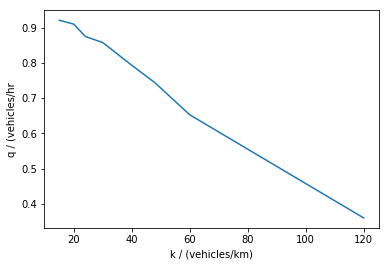

In [30]:
TL = 10
plt.plot([den(1),den(3),den(4),den(5),den(7),den(9),den(11),den(15)],
         [effRT(1,TL),effRT(3,TL),effRT(4,TL),effRT(5,TL),effRT(7,TL),
          effRT(9,TL),effRT(11,TL),effRT(15,TL)])
plt.xlabel('k / (vehicles/km)')
plt.ylabel('q / (vehicles/hr')
plt.show()

### Comparision between three control types

In this section, we compare different control types.

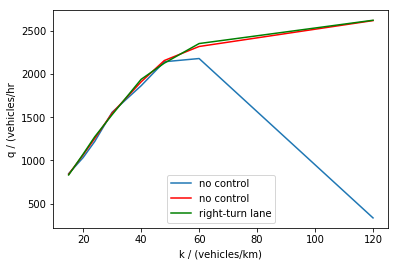

In [31]:
TL = 10

plt.plot([den(1),den(3),den(4),den(5),den(7),den(9),den(11),den(15)],
         [outflow(1),outflow(3),outflow(4),outflow(5),outflow(7),outflow(9),outflow(11),outflow(15)],label='no control')

plt.plot([den(1),den(3),den(4),den(5),den(7),den(9),den(11),den(15)],
         [outflowTL(1,TL),outflowTL(3,TL),outflowTL(4,TL),outflowTL(5,TL),outflowTL(7,TL),
          outflowTL(9,TL),outflowTL(11,TL),outflowTL(15,TL)],'r-',label='no control')

plt.plot([den(1),den(3),den(4),den(5),den(7),den(9),den(11),den(15)],
         [outflowRT(1,TL),outflowRT(3,TL),outflowRT(4,TL),outflowRT(5,TL),outflowRT(7,TL),
          outflowRT(9,TL),outflowRT(11,TL),outflowRT(15,TL)],'g-',label='right-turn lane')

plt.xlabel('k / (vehicles/km)')
plt.ylabel('q / (vehicles/hr')
plt.legend()
plt.show()

### Recommendations

From the output, we draw the following conclusions:

(i) We recommend no-control for intersections with traffic flow density less than 40 vehicle/km.  

(ii) We recommend signal control for intersections with traffic flow density higher than 40 vehicle/km. 

(iii) The cycle length of the traffic signal should be as low as possible.

(iv) A designated right turn lane improves the intersection capacity, but not much.

### Future work

In our recommendation, we did not consider safety factors and we did not quantify the influence ofs start-up lost time.  We can also study whether we can benefit more from designated right-turn lane if the percent of right-turn vehicles increases.